# Data Pre-processing

The dataset used for the mental health classifier creation can be found [here](https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health). This dataset consists of around 53k datapoints and has 7 classes (Anxiety, Depression, Bipolar, Personality Disorder, Stress, Normal, and Suicidal). The datapoints are made up of texts from different sources (reddit posts, tweets, etc..), with each datapoint having a label corresponding to a mental health condition. This notebook is run in google colab.

## Importing the dataset

In order to download the dataset, I will be using the kaggle API. The cells below allow for the upload of the json file you can download from your kaggle profile, as well as downloading the dataset itself.

In [1]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [2]:
!kaggle datasets download "suchintikasarkar/sentiment-analysis-for-mental-health"
!unzip sentiment-analysis-for-mental-health.zip

Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
sentiment-analysis-for-mental-health.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment-analysis-for-mental-health.zip
replace Combined Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import pandas as pd


In [22]:
df = pd.read_csv('/content/Combined Data.csv', index_col=0)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


## Data Pre-processing

<ipython-input-23-91ae10ef772a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="pastel")


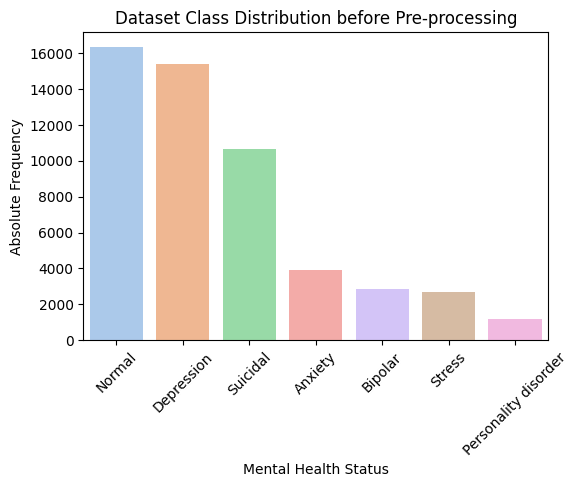

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each category
status_counts = df['status'].value_counts()

# Create bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=status_counts.index, y=status_counts.values, palette="pastel")

# Customizing the plot
plt.title("Dataset Class Distribution before Pre-processing")
plt.xlabel("Mental Health Status")
plt.ylabel("Absolute Frequency")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


In [24]:
print(f"Dataset size: {len(df)}")


Dataset size: 53043


Looking at the graph above, it is evident that the dataset is extremely unbalanced. There are also classes that are out of the scope of the thesis (Stress, Bipolar, and Personality disorder) as they are either not a mental health condition, or can be a hereditary disease. Hence, they will be dropped, along with the usual steps of dropping na values, dropping duplicates, and removing special symbols. I also remove any datapoints that have a character length longer than 1000 as the indicators will be created later on using tweets, which have a maximum length of around 900 characters. The last step is to use the DeepL library to translate the datapoints into italian as the tweets used for the indicators are in Italian.

In [25]:
import re
df = df.drop_duplicates(subset='statement')
print(f"Dataset size: {len(df)}")
df = df.dropna()
df = df.reset_index(drop=True)
df = df[df['statement'].str.len() <= 1000]
def clean_text(text):
    if isinstance(text, str):
        text = text.replace('\n', ' ')
        return re.sub(r'[^A-Za-z0-9\s.!?,;:()\"\'#-]', '', text)
    return text

df["statement"] = df["statement"].apply(clean_text)
print(f"Dataset size: {len(df)}")

Dataset size: 51074
Dataset size: 42165


In [26]:
label_counts = df['status'].value_counts()
print(label_counts)

status
Normal                  16033
Depression              10889
Suicidal                 8233
Anxiety                  2705
Stress                   2047
Bipolar                  1676
Personality disorder      582
Name: count, dtype: int64


Finally, we sample the dataset in order to make it more balanced, while ensuring that enough datapoints are enough to properly train the models.

In [27]:
from sklearn.model_selection import train_test_split
import pandas as pd

classes = df.status.unique()
df.dropna(inplace=True)

# Drop unnecessary classes
mapping = {'Depression': 0, 'Normal': 1, 'Anxiety': 2, 'Suicidal': 3}
df['status'] = df['status'].map(mapping)
df.columns = ['text', 'label']
df = df[df.label.isin([0, 1, 2, 3])]

X_train, X_val, X_test = [], [], []

for sentiment in df.label.unique():
    if sentiment ==2:
        #class_df = df[df.label == sentiment].sample(n=3600, random_state=42, replace=False)
        class_df = df[df.label == sentiment].sample(n=2700, random_state=42, replace=False)
        train_size = 2700-540
        val_test_size = 270
        #train_size = 2880
        #val_test_size = 360

        train = class_df[:train_size]
        val = class_df[train_size:train_size + val_test_size]
        test = class_df[train_size + val_test_size:]

        X_train.append(train)
        X_val.append(val)
        X_test.append(test)
    else:
                #class_df = df[df.label == sentiment].sample(n=3600, random_state=42, replace=False)
        class_df = df[df.label == sentiment].sample(n=4000, random_state=42, replace=False)
        train_size = 4000-800
        val_test_size = 400
        #train_size = 2880
        #val_test_size = 360

        train = class_df[:train_size]
        val = class_df[train_size:train_size + val_test_size]
        test = class_df[train_size + val_test_size:]

        X_train.append(train)
        X_val.append(val)
        X_test.append(test)


X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_val = pd.concat(X_val)
X_test = pd.concat(X_test)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


X_train.to_csv('Training dataset/train.csv', index=False)
X_val.to_csv('Training dataset/val.csv', index=False)
X_test.to_csv('Training dataset/test.csv', index=False)

Training set size: 11760
Validation set size: 1470
Test set size: 1470


The final dataset distribution is shown below.

<ipython-input-28-0397c9df2e5e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=label_counts, palette="pastel")


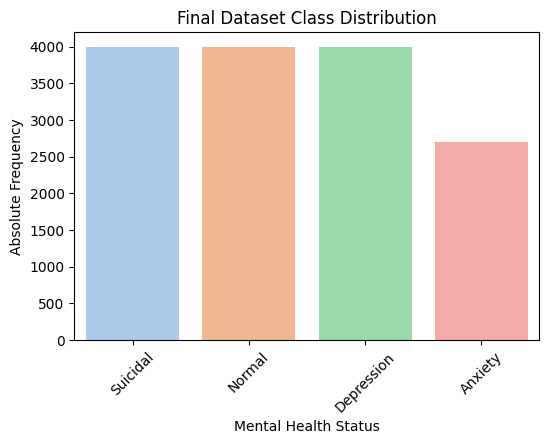

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Map numerical labels to categorical labels
id2label = {0: 'Depression', 1: 'Normal', 2: 'Anxiety', 3: 'Suicidal'}
X_train['label'] = X_train['label'].map(id2label)
X_val['label'] = X_val['label'].map(id2label)
X_test['label'] = X_test['label'].map(id2label)

# Combine datasets
X_combined = pd.concat([X_train, X_val, X_test], ignore_index=True)

# Count occurrences of each class
label_counts = X_combined['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']  # Rename columns for clarity

# Plot bar chart using Seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x='label', y='count', data=label_counts, palette="pastel")

# Customizing the plot
plt.title("Final Dataset Class Distribution")
plt.xlabel("Mental Health Status")
plt.ylabel("Absolute Frequency")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


## Translation

In [ ]:
!pip install deep-translator
import pandas as pd
import os
from tqdm import tqdm
from deep_translator import GoogleTranslator
import csv


In [ ]:
X_train['text'] = X_train['text'].astype(str)
X_val['text'] = X_val['text'].astype(str)
X_test['text'] = X_test['text'].astype(str)

In [ ]:
from deep_translator import GoogleTranslator
from tqdm import tqdm

translator = GoogleTranslator(source="en", target="it")

tqdm.pandas()

X_val["italian text"] = X_val["text"].progress_apply(lambda x: translator.translate(x) if isinstance(x, str) else x)
X_test["italian text"] = X_test["text"].progress_apply(lambda x: translator.translate(x) if isinstance(x, str) else x)
X_train["italian text"] = X_train["text"].progress_apply(lambda x: translator.translate(x) if isinstance(x, str) else x)
X_val.to_csv("Training dataset/val.csv", index=False)
X_test.to_csv("Training dataset/test.csv", index=False)
X_train.to_csv("Training dataset/train.csv", index=False)
